# Bayesian A/B Testing

We try to do A/B testing. We have sites A and B we want to find the probability $p_A$ and $p_B$, which is the probability that the user will purchase from $A$ and $B$ after they have been shown the websites.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pymc as pm

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [37]:
# Unknown True Probabailities pA and pB
p_A = 0.05
p_B = 0.04

# Number of testings on A and B
N_A = 5000
N_B = 1600

# generating Datasets for A and B
obs_A = stats.bernoulli.rvs(p_A, size = N_A)
obs_B = stats.bernoulli.rvs(p_B, size = N_B)

obs_freq_A = obs_A.mean()
obs_freq_B = obs_B.mean()


In [38]:
obs_freq_A,obs_freq_B

(0.0466, 0.038125)

In [39]:
with pm.Model() as model:
    pA = pm.Uniform("pA", 0, 1)
    pB = pm.Uniform("pB", 0, 1)


    delta = pm.Deterministic("delta", pA-pB)
    
    obsA = pm.Bernoulli("obsA", pA, observed = obs_A)
    obsB = pm.Bernoulli("obsB", pB, observed = obs_B)

In [40]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(20000, step=step,chains=2)

Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>Metropolis: [pA]
>Metropolis: [pB]


/home/sab/miniconda3/envs/jupyter/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" 
for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/sab/miniconda3/envs/jupyter/lib/python3.12/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
/home/sab/miniconda3/envs/jupyter/lib/python3.12/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 2 chains for 1_000 tune and 20_000 draw iterations (2_000 + 40_000 draws total) took 18 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [41]:
p_A_samples =  np.concatenate(trace.posterior.pA.data[:,1000:])
p_B_samples =  np.concatenate(trace.posterior.pB.data[:,1000:])
delta_samples = np.concatenate(trace.posterior.delta.data[:,1000:])

In [42]:
norm = stats.norm
paramA = norm.fit(p_A_samples)
paramB = norm.fit(p_B_samples)
paramDelta = norm.fit(delta_samples)

In [49]:
x = np.linspace(-0.1,0.1,1000)
probA = norm.pdf(x, *paramA)
probB = norm.pdf(x, *paramB)
probD = norm.pdf(x, *paramDelta)

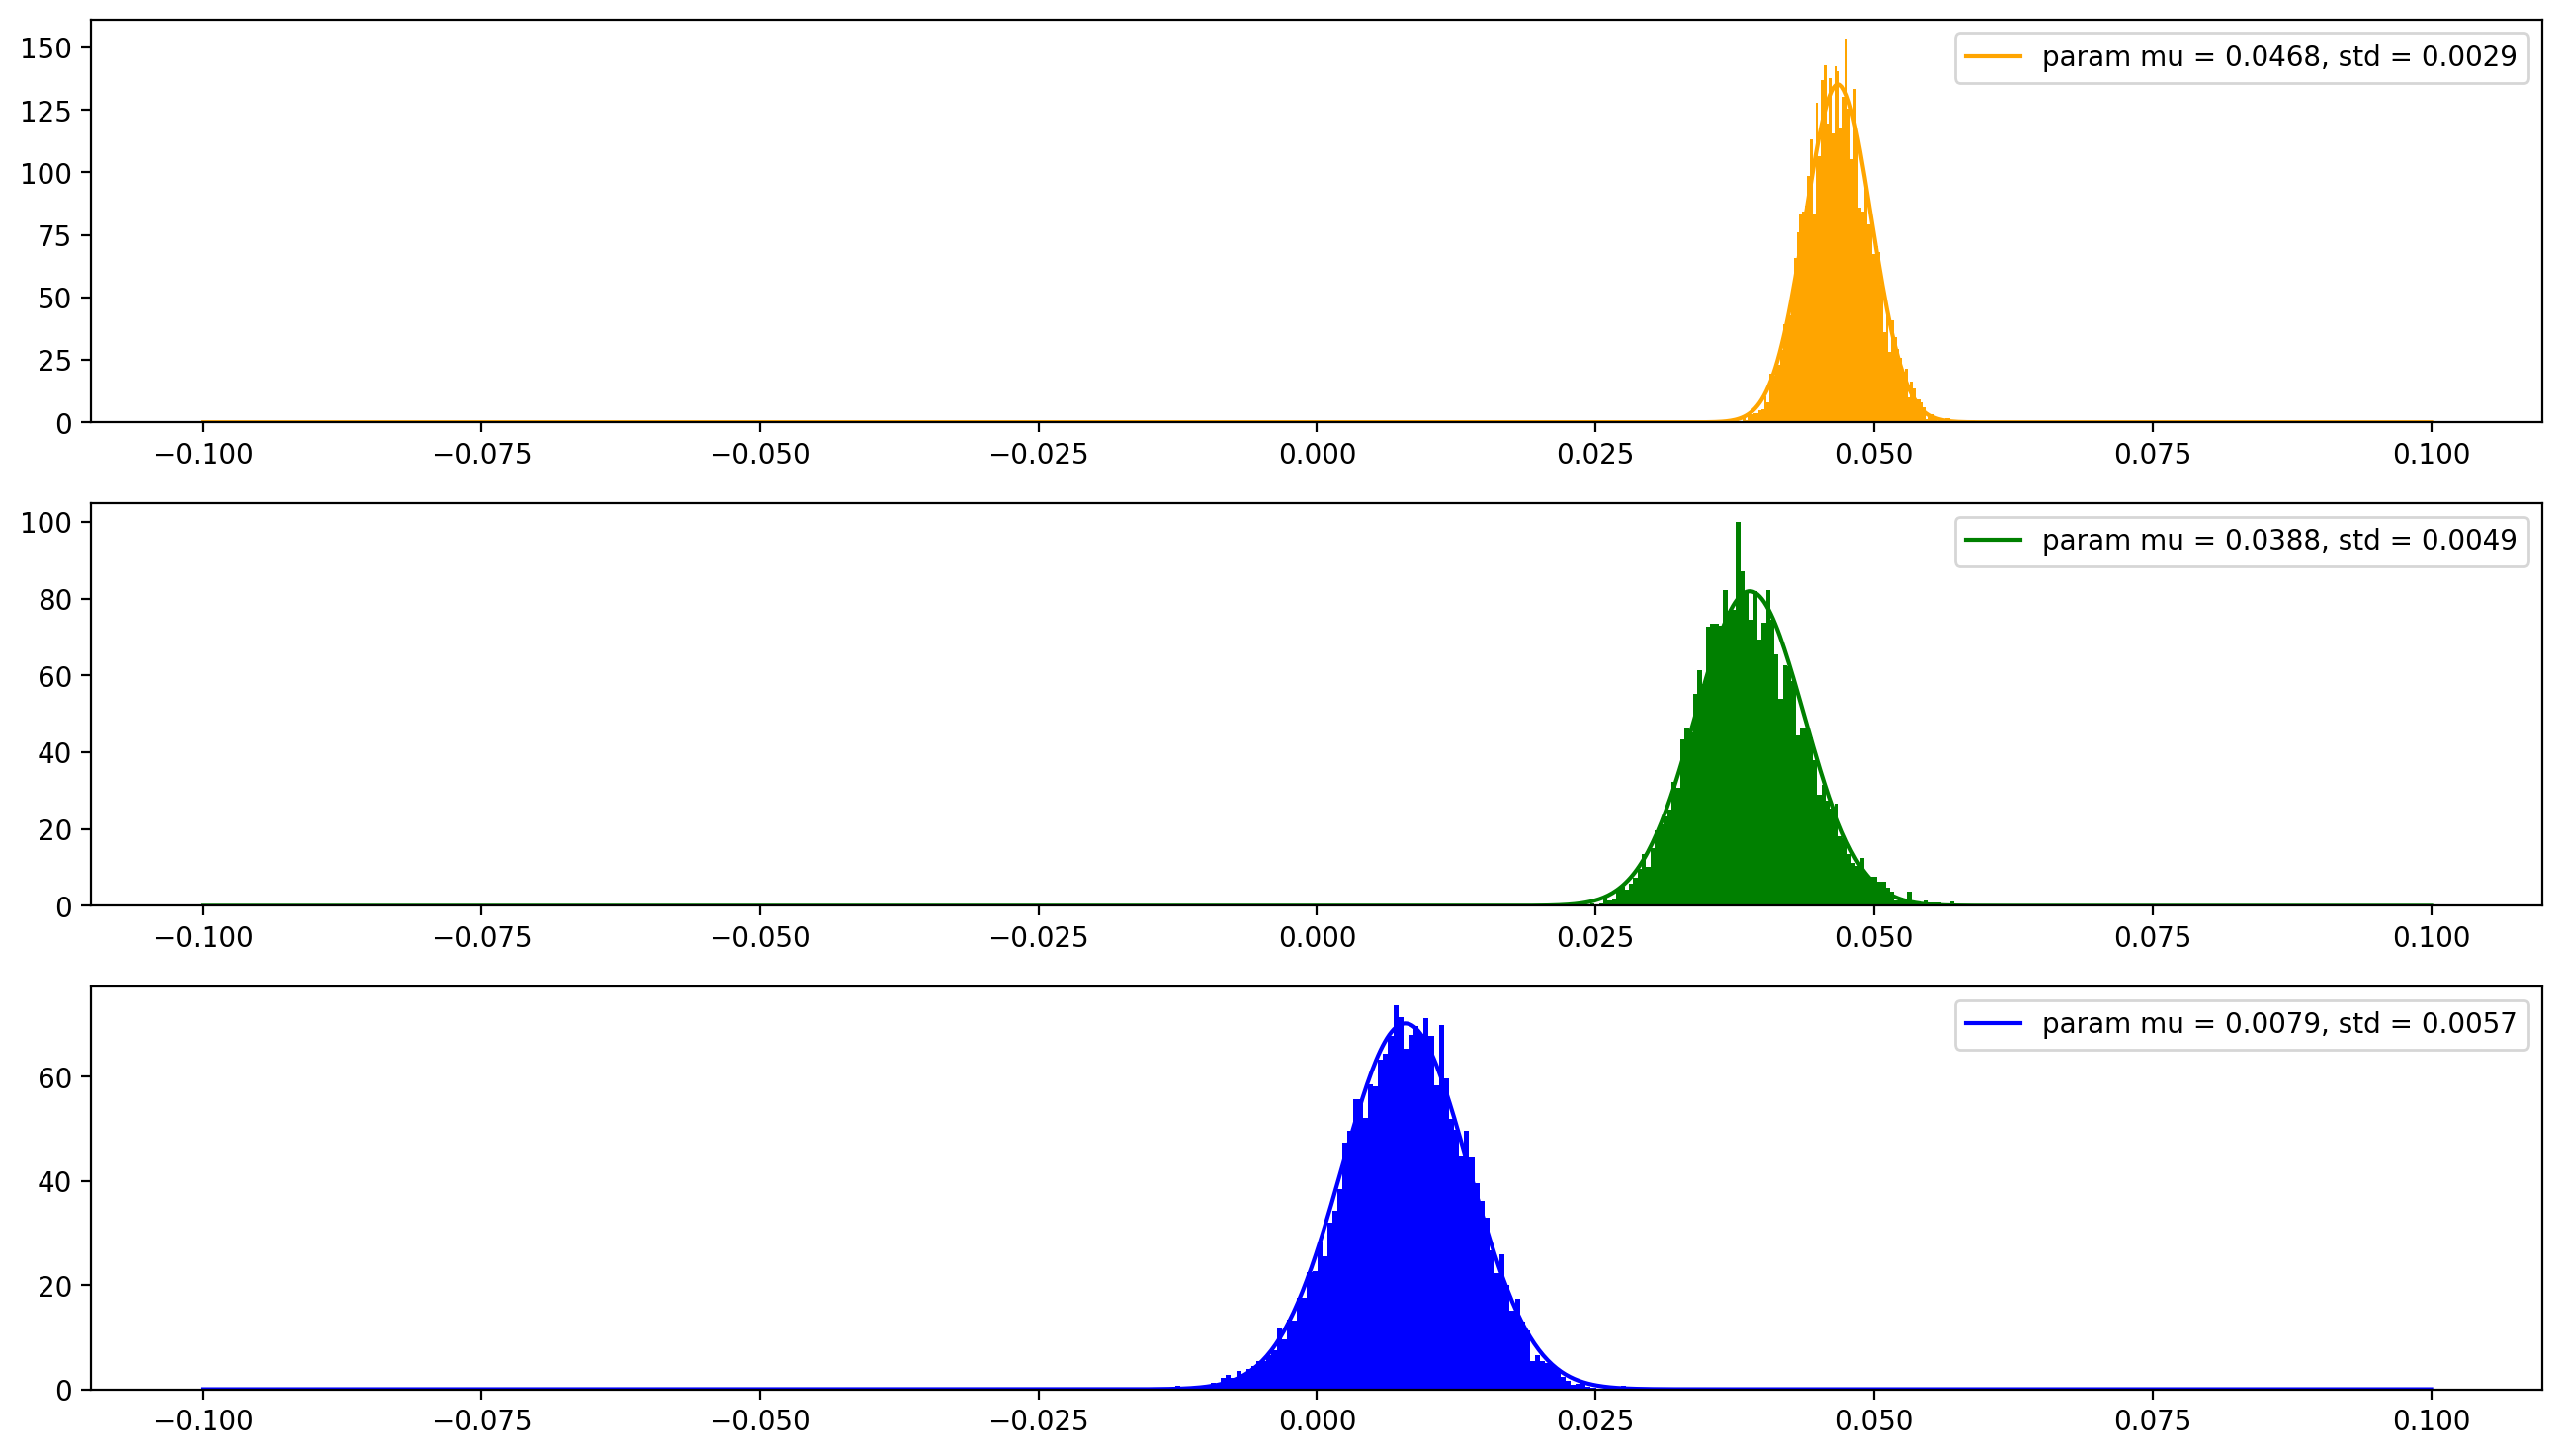

In [50]:
fig, axes = plt.subplots(3, 1, figsize = (16, 9), dpi = 200)
axes[0].hist(p_A_samples, density = True, bins = 100, color = "orange");
axes[0].plot(x, probA, color = 'orange', label = f"param mu = %.4f, std = %.4f"%(paramA[0],paramA[1]))
axes[0].legend()
axes[1].hist(p_B_samples, density = True, bins = 100, color = "g");
axes[1].plot(x, probB, color = 'g', label = f"param mu = %.4f, std = %.4f"%(paramB[0],paramB[1]))
axes[1].legend()
axes[2].hist(delta_samples, density = True, bins = 100, color = "b");
axes[2].plot(x, probD, color = 'b', label = f"param mu = %.4f, std = %.4f"%(paramDelta[0],paramDelta[1]))
axes[2].legend()